In [39]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from matplotlib.colors import Normalize

# To Do
* Put GTEx demo spreadsheet into data
* Put GTEx expression spreadsheet (OR LINK) into data
* Put GTEx demo 2 spreadsheet into data
* Put GTEx exclusion spreadsheet into data
* Put GTEx gene spreadsheet into data
* Link "comps" df path to path generated from previous notebook
* Change all the spreadsheet paths
* Add script to prep GTEx data
* Add instructions about the spreadsheet
* Add information about missing Age

# Instructions

In order to run this notebook, you will need to do the following steps:

1) Download the following (version 8) GTEx data from https://gtexportal.org/home/datasets:
* GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt
* GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt
* GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz

Unzip and move into `./data/`

2) Preprocess the data. To do so, run the R script found in `code/GTEx_v8_process.R`. Note that you will first need to ensure several packages and their dependencies are installed: WGCNA, SNFtool, flashClust, CePa, plyr. ***IMPORTANT! This script has not been successfully run on R version 4.x. Please us version 3.x***

***NOTE*** The publicly available GTEx data has binned ages, rather than true ages. For the manuscript, we used "Protected Data" which has the true ages of donors. Therefore, this is perhaps the only manuscript analysis that you will not be able to run yourself with online data. We will include the exact code we ran, and you can substitute our (true) age variable with the binned age variable. But note there will be differences in the results.

The section below can be used to download and process the raw data. However, this requires R and some R libraries. Thus, this is commented out, and we suggest downloading the outputs we have prepared from this snippet.

In [17]:
# os.system('wget https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt')
# os.system('wget https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt')
# os.system('wget https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz')
# os.system('mv *GTEx* data')
# os.system('R code/GTEx_v8_process.R')

This code will simply load the pre-run data. you can look at code/GTEx_v8_process.R for details

In [2]:
os.system('wget https://www.dropbox.com/sh/zx0va2j8tbbyhux/AAC0oTSl0Of_mazw3fZGeqpua/GTEx_brain_norm_noregress.csv?dl=1')
os.system('wget https://www.dropbox.com/sh/zx0va2j8tbbyhux/AACb8ZPPb495vnIUKCfrQnSBa/GTEx_brain_norm_noregress_meta.csv?dl=1')
os.system('mv *norm_nogress* data/')

256

# Prep data

In [6]:
df = pandas.read_csv('data/GTEx_brain_norm_noregress_meta.csv')

In [7]:
df.head()

,Unnamed: 0,SUBJID,RIN,BATCH,GBATCH,AGE,SEX,SMTSD,SeqPC1,SeqPC2,SeqPC3,SeqPC4,SeqPC5
0,GTEX-1117F-3226-SM-5N9CT,GTEX-1117F,6.2,BP-43956,LCSET-4904,65,2,Brain - Cortex,0.730214,1.373728,-0.032430,-1.243091,-0.269011
1,GTEX-111FC-3126-SM-5GZZ2,GTEX-111FC,6.1,BP-43693,LCSET-4804,65,1,Brain - Cortex,-0.877245,0.217794,-0.722488,-2.620600,0.325254
2,GTEX-111FC-3326-SM-5GZYV,GTEX-111FC,7.1,BP-43507,LCSET-4804,65,1,Brain - Cerebellum,2.723758,-1.893202,-3.023749,-1.072355,-0.128278
3,GTEX-1128S-2726-SM-5H12C,GTEX-1128S,6.3,BP-43783,LCSET-4805,65,2,Brain - Cortex,-0.511056,0.888433,0.002476,-1.154150,0.026175
4,GTEX-1128S-2826-SM-5N9DI,GTEX-1128S,6.3,BP-43956,LCSET-4904,65,2,Brain - Cerebellum,4.048402,-1.947349,-3.737918,1.363319,-0.354989


In [10]:
meta = pandas.read_csv('data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
                      sep='\t')
meta.shape

Note that here I am getting the true age information from an internal spreadsheet. You will skip this step (unless you have access to the GTEx Protect Data, in which case you may change the path below so it points to your own spreadsheet

In [11]:
# bwdf = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_meta_forJake.csv')
# bwcols = ['AGE']
# df.loc[:,'merger'] = ['%s_%s'%(df.loc[x,'SUBJID'],
#                                df.loc[x,'SMTSD']) for x in df.index]
# bwdf.loc[:,'merger'] = ['%s_%s'%(bwdf.loc[x,'SUBJID'],
#                                bwdf.loc[x,'SMTSD']) for x in bwdf.index]
# jnk = pandas.DataFrame(df,copy=True)
# jnk.loc[:,'old_ind'] = jnk.index.values
# jnk.index = jnk.merger.values
# bwdf.index = bwdf.merger.values
# shared = list(set(bwdf.index) & set(jnk.index))
# for col in bwcols:
#     jnk.loc[shared,col] = bwdf.loc[shared,col].values
#     df.loc[:,col] = jnk.loc[:,col].values

In [12]:
# number of samples
len(df.SUBJID.unique())

376

We also want to make sure that our results aren't driven by individuals with brain diseases. Another recent paper (10.1038/s41593-021-00887-5) recommended an extreme processing stream for the GTEx that, among other rather heavy-handed steps, excluded all individuals who died of/with brain disease. 

Attached is a spreadsheet of GTEx donors remaining after this preprocessing was done. By cross-referencing our spreadsheet (with everyone) with this list of donors (without individuals with brain disease), we can ID who is who

In [13]:
excludf = pandas.read_csv('data/GTEx_healthy.csv',index_col=0)
excludf.loc[:,'Healthy'] = [x.replace('.','-') for x in excludf.Healthy.values]
dx_exclude = list(set(df.SUBJID.values) - set(excludf.Healthy.values))
df.loc[df.SUBJID.isin(dx_exclude),'Excl_Dx'] = 1
df.loc[df.Excl_Dx!=1,'Excl_Dx'] = 0

In [14]:
len(dx_exclude)

151

Note, to run the next line, you will have needed to run the GTEx processing script first (see instructions above).

In [17]:
# load processed expression data 
exp = pandas.read_csv('data/GTEx_brain_norm_noregress.csv')

In [18]:
exp.shape

(15758, 2484)

In [19]:
exp.columns = ['ENSGID'] + exp.columns[1:].tolist()

In [20]:
# spreadsheet to map gene symbol (Allen) to ensemble gene ID (GTEx)
genes = pandas.read_csv('data/gene_info.csv')
genes.head()

,hgnc_symbol,ensembl_gene_id,chromosome_name,start_position,end_position,entrezgene_id
0,FGR,ENSG00000000938,1,27612064,27635185,2268.0
1,STPG1,ENSG00000001460,1,24356999,24416934,90529.0
2,NIPAL3,ENSG00000001461,1,24415802,24472976,57185.0
3,AK2,ENSG00000004455,1,33007940,33080996,204.0
4,KDM1A,ENSG00000004487,1,23019443,23083689,23028.0


# Whole dataset congruence

#### Preprocess
Here, we will match the GTEx genes with the Allen genes in order to derive PLS components for GTEx samples

In [21]:
gdict = dict(zip(genes.ensembl_gene_id.values,
                genes.hgnc_symbol.values))
gmatch = [np.nan if x not in gdict.keys() else \
          gdict[x] for x in exp.ENSGID.values]
exp.loc[:,'gene_symbol'] = gmatch
exp.dropna(inplace=True)

In [22]:
# NOTE: This spreadsheet was generated from the ModelExploration notebook 
comps = pandas.read_csv('tables/all_comps.csv',index_col = 0)
comps.head()

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
0,A1BG,alpha-1-B glycoprotein,0.002967,0.001055,-0.005412,0.0,0.0,0.0
1,A1BG-AS1,NaN,0.001287,-0.001796,0.006987,0.0,0.0,0.0
2,A2M,alpha-2-macroglobulin,0.003203,0.003630,0.000001,0.0,0.0,0.0
3,A2ML1,alpha-2-macroglobulin-like 1,-0.000960,-0.003713,-0.009880,0.0,0.0,0.0
4,A3GALT2,NaN,-0.002451,0.001712,0.003116,0.0,0.0,0.0


#### Match genes

In [23]:
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
len(shared_genes)

12647

In [24]:
# Harmonizing expression data with genes shared between both datasets
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
                                 copy=True)
exp = pandas.DataFrame(exp[exp.gene_symbol.isin(shared_genes)],
                                copy=True)

In [25]:
# saving the index for a moment
egenes = exp.gene_symbol.values

Are we harmonized?

In [26]:
exp.shape

(12647, 2485)

In [27]:
matched_comps.shape

(12647, 8)

Yep!

#### regress covariates

Here we are going to regress out the first five "Sequence PCs" from the data. These are PCs derived from confounding covariates (see processing script). ***Note:*** This took a few minutes on my computer
 

In [38]:
# Make empty dataframe
nexp = np.zeros_like(exp.iloc[:,1:-1].values)
# get small table with only relevant covariates
dat = pandas.DataFrame(df[df.columns[8:13]],copy=True)

# regress covariates
count = 0
# for each gene
for i,row in exp.iterrows():
    # fit model regressing the PCs
    dat.loc[:,'exp'] = row.values[1:-1].astype(float)
    mod = smf.ols('exp ~ SeqPC1 + SeqPC2 + SeqPC3 + SeqPC4 + SeqPC5',
                  data=dat).fit()
    # save residuals
    nexp[count,:] = mod.resid.values
    # keep track
    if count%100==0:
        print('finished %s of %s'%(count+1,len(nexp)))
    count+=1

finished 1 of 12647
finished 101 of 12647
finished 201 of 12647
finished 301 of 12647
finished 401 of 12647
finished 501 of 12647
finished 601 of 12647
finished 701 of 12647
finished 801 of 12647
finished 901 of 12647
finished 1001 of 12647
finished 1101 of 12647
finished 1201 of 12647
finished 1301 of 12647
finished 1401 of 12647
finished 1501 of 12647
finished 1601 of 12647
finished 1701 of 12647
finished 1801 of 12647
finished 1901 of 12647
finished 2001 of 12647
finished 2101 of 12647
finished 2201 of 12647
finished 2301 of 12647
finished 2401 of 12647
finished 2501 of 12647
finished 2601 of 12647
finished 2701 of 12647
finished 2801 of 12647
finished 2901 of 12647
finished 3001 of 12647
finished 3101 of 12647
finished 3201 of 12647
finished 3301 of 12647
finished 3401 of 12647
finished 3501 of 12647
finished 3601 of 12647
finished 3701 of 12647
finished 3801 of 12647
finished 3901 of 12647
finished 4001 of 12647
finished 4101 of 12647
finished 4201 of 12647
finished 4301 of 12647


In [39]:
# update the expression dataset with the residuals
exp = pandas.DataFrame(nexp,index=exp.index,columns=exp.columns[1:-1])

In [40]:
exp.loc[:,'gene_symbol'] = egenes

In [41]:
exp.sort_values('gene_symbol',inplace=True)

In [42]:
# You might want to save this so you dont have to run the regression again
# exp.to_csv('data/GTex_harmed_GExp.csv')

# Analyses -- replication

The objective here is to see if the PLS Components derived in AHBA "reproduce" in GTEx. 

The way we're doing this is taking the PLS Model trained on Allen data and applying it to the GTEx data. We compare the "transformed" GTEx data based on gene expression to the transformed Allen data by correlating the transformed values of both datasets across regions. The reason this works is because Y is spatial location, and regions are spatially embedded.

So, what we are essentially doing here is just ensuring that the genes expressed in the Allen PLS Components are expressed in a similar regional pattern in GTEx as they are in AHBA. Another way to think about it is we are looking to see how similar the two are datasets with a specific focus on the expression of genes contributing to the AHBA PLS Components. See the XSpecies.ipynb for different null models.

This is an important step because a) we see how robust the regional expression of PLS Components in a separate dataset, and b) it is necessary to show a very high correlation across datasets if we want to look at how the PLS Components vary over age in the GTEx dataset.

In [43]:
## Load the data if it was already saved
#exp = pandas.read_csv('data/GTex_harmed_GExp.csv',index_col=0)

We want to be able to test how robust the reproducibility is to age of the sample (everyone vs only those in the AHBA age range), cognitive status (everyone vs only those w/o brain disorder at death), and the interaction of these features.

So, we'll create separate subsamples that include:
* full -- Everyone
* younger -- everyone <= 60
* ctrl -- all "controls" (weren't excluded by stringent pipeline)
* yctrl -- all "controls" <= 60

In [36]:
# create these "datasets"
younger = df[df.AGE<61][df.columns[0]].values
cntrl = df[df.Excl_Dx==0][df.columns[0]].values

In [32]:
# change this to the location you saved your abagen data
allendir = '/Users/jacobv/abagen-data/microarray/'

In [33]:
# Load the Allen Human Brain data in order to refit the PLS model

# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [34]:
# reduce the genes included in the PLS to those included in both
# the Allen Human Brain Atlas and GTEx datasets
hbigdf = hbigdf[exp.gene_symbol.values]

In [40]:
# fit the PCA to this reduced set of AHBA genes
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)

In [56]:
# and then the AHBA PLS model
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)


PLSRegression(n_components=3)

One of the components ends up being "inverted" comparing to the original PLS fit with all genes. In other words, the component is very similar, but the weights are inverted. This happens a lot and is not a big deal. To prevent confusion, we'll just invert the component loadings. This is as simple as multiplying them by -1

In [57]:
# deal with reversed component
multiplier = np.array([np.ones(pls_mod.x_rotations_.shape[0]),
          np.ones(pls_mod.x_rotations_.shape[0]),
          np.ones(pls_mod.x_rotations_.shape[0])]).T
multiplier[:,2] = -1

pls_mod.x_rotations_ *= multiplier

In order to successfully replicate this analysis, we need to try to get the GTEx genes into a similar data space as the AHBA data. This means we want the values to be between 0 and 1, so we'll sue a min-max scaler. In addition, since the AHBA subjects are between the ages of 20 and 60, we want to make sure we train the MinMax scaler specifically on donors within this age range, and who don't have other issues that may affect the signal. Accordingly, we'll  go through the following steps for replication:

1) 0-1 Transform the GTEx data using "young controls"

2) Use the PCA model trained on the Allen data to transform the GTEx data into components

3) Use the PLS model trained on the Allen data to transform the GTEx components to LVS

In [58]:
# create dataframe with the important columns
scols = exp.columns[:-1]
pred = pandas.DataFrame()
pred.loc[:,'sample'] = scols
pred.loc[:,'Region'] = df.loc[:,'SMTSD'].values

In [59]:
# normalize by young controls
n_comps=3
# min-max scale by young controls
mmmod = MinMaxScaler().fit(exp[list(set(cntrl) & set(younger))].T)
# apply AHBA PCA model to GTEx data
hb_pcatfm = pcamod.transform(mmmod.transform(exp[exp.columns[:-1]].T))
# apply AHBA PLS to GTEx components
xtfm = pls_mod.transform(hb_pcatfm)
# store transformations
for c in range(n_comps):
    pred.loc[:,'C%s'%(c+1)] = xtfm[:,c]

In [60]:
# Make a mapping between GTEx brain regions and AHBA divisions
rkey = dict(zip(pred.Region.unique(),
               ['Frontal','Cerebellum','Frontal','Caudate','Accumbens',
               'Putamen','Hypothalamus','Hippocampus','AntCing',
               'Cerebellum','Nigra','Amygdala']))

In [61]:
# add to new dataframe
for i,row in pred.iterrows():
    pred.loc[i,'Div'] = rkey[row['Region']]

In [62]:
# How are we doing
pred.head()

,sample,Region,C1,C2,C3,Div
0,GTEX-1117F-3226-SM-5N9CT,Brain - Cortex,-0.000865,-0.295222,1.000281,Frontal
1,GTEX-111FC-3126-SM-5GZZ2,Brain - Cortex,-0.246158,-0.153416,0.329235,Frontal
2,GTEX-111FC-3326-SM-5GZYV,Brain - Cerebellum,0.433798,-0.037611,0.253396,Cerebellum
3,GTEX-1128S-2726-SM-5H12C,Brain - Cortex,-0.394155,-0.200781,1.161674,Frontal
4,GTEX-1128S-2826-SM-5N9DI,Brain - Cerebellum,0.310180,-0.153596,0.764623,Cerebellum


In [63]:
# create separate subsets according to "young" or "control" status
datasets = {'full': pred.groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'younger': pred[pred['sample'].isin(younger)
                                 ].groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'ctrl': pred[pred['sample'].isin(cntrl)
                        ].groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'yctrl': pred[(pred['sample'].isin(cntrl)) & (pred['sample'].isin(younger))
                        ].groupby('Div')[['C1','C2','C3']].mean().sort_index()
           }
for nm,gtC in datasets.items():
    gtC.loc[:,'GTeX_div'] = gtC.index
    
# show an example
datasets['full']

,C1,C2,C3,GTeX_div
Div,,,,
Accumbens,-0.002636,0.363786,0.563030,Accumbens
Amygdala,0.205626,0.065847,0.173163,Amygdala
AntCing,-0.248048,0.455739,1.088403,AntCing
Caudate,-0.188800,0.231241,0.518303,Caudate
Cerebellum,0.482063,-0.146904,0.554027,Cerebellum
Frontal,-0.317494,-0.059244,0.842851,Frontal
Hippocampus,0.145826,-0.005940,0.416169,Hippocampus
Hypothalamus,0.241812,0.272148,0.620508,Hypothalamus
Nigra,0.356851,0.010105,0.427258,Nigra


========== full ==========
r = 0.949, p = 0.0


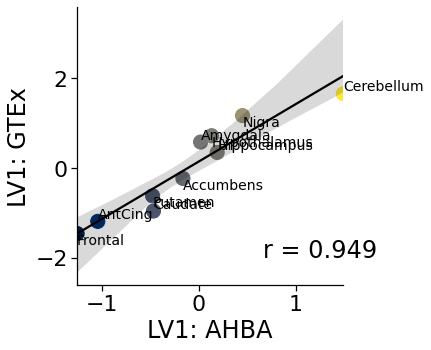

r = 0.822, p = 0.003


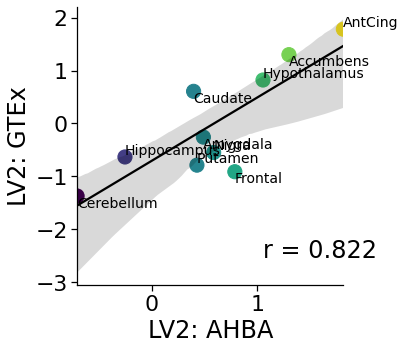

r = 0.474, p = 0.166


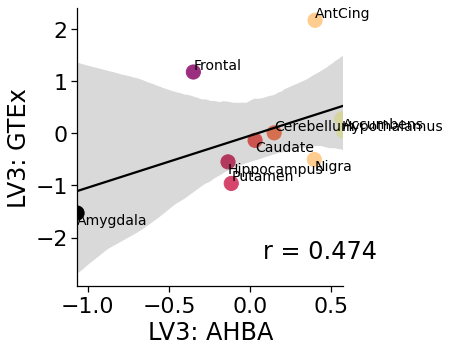

========== younger ==========
r = 0.951, p = 0.0


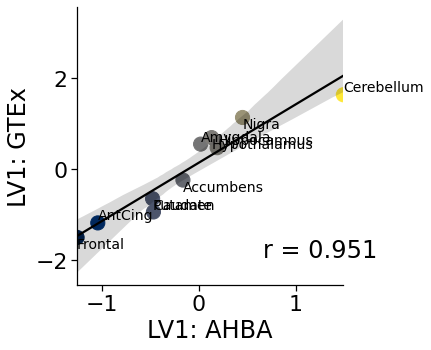

r = 0.844, p = 0.002


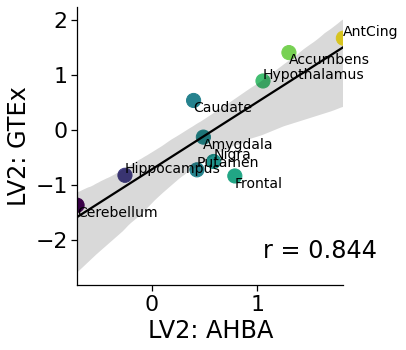

r = 0.463, p = 0.178


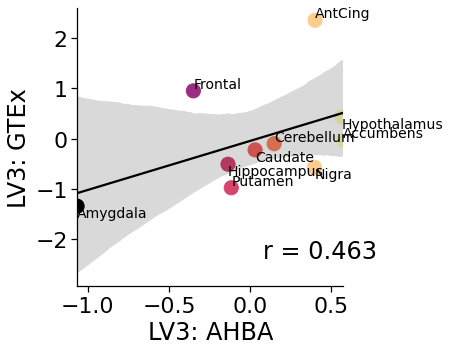

========== ctrl ==========
r = 0.951, p = 0.0


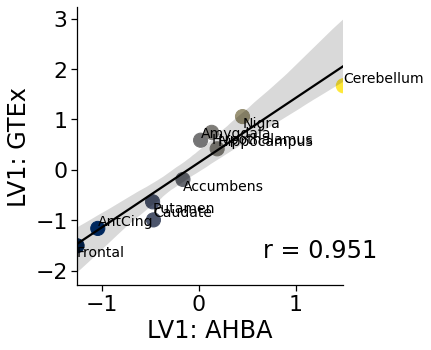

r = 0.837, p = 0.003


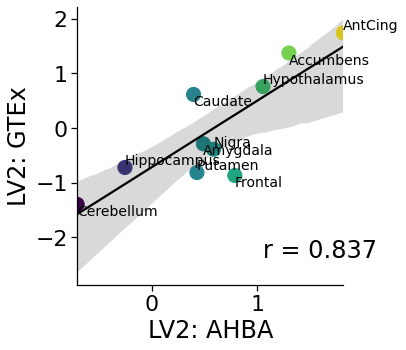

r = 0.503, p = 0.138


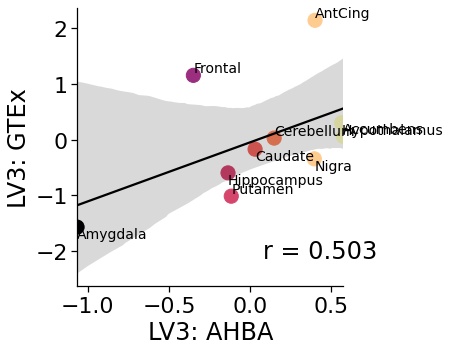

========== yctrl ==========
r = 0.948, p = 0.0


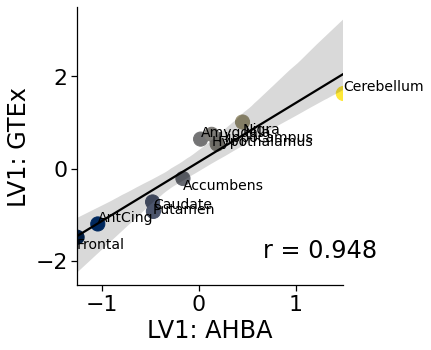

r = 0.866, p = 0.001


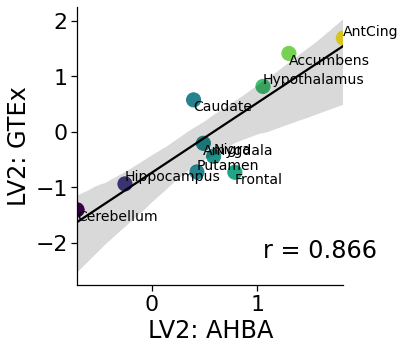

r = 0.487, p = 0.154


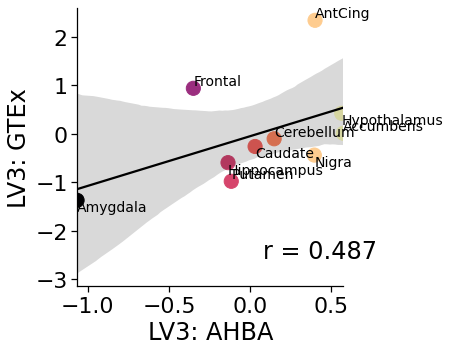

In [64]:
# Run replication analysis and plot

fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'
sns.set_context('notebook',font_scale=2)

# color scales for lines
pals = ['cividis','viridis','magma'] 

# used to control location of text within plot
# I havent messed with this in awhile as I ended up moving the text
# manually after creating the figure. Like a pleb.
scale = {1:0.02,2:0.015,3:0.008} 

# for each dataset
for nm,gtC in datasets.items(): 
    print('%s %s %s'%(('='*10),nm,('='*10)))
    # for each PLS component
    for i in range(1,4):
        # standardize data (because no intercept) -- pattern expression
        vals = StandardScaler().fit_transform(gtC.loc[:,'C%s'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
        gtC.loc[:,'zC%s'%i] = vals
        # Load Allen component data
        allen = pandas.read_csv('data/GCorr_GTexComp_ABA_C%s_data_ROTATION.csv'%i
                               ).sort_values('GTeX_div')
        allen.index = allen.GTeX_div.values
        allen.drop('Pallidum',axis=0,inplace=True)
        # concatenate GTEx and AHBA data for seaborn plotting
        plotr = pandas.concat([pandas.Series(allen['C%s_Expression'%i
                                                  ].values),
                               pandas.Series(gtC['zC%s'%i].values)],
                              axis=1)
        plotr.columns = ['Allen','GTEx']
        plotr.index = allen.GTeX_div.values

        # add pretty colors (...for continuity!)
        # normalize colorscale of markers by AHBA values
        cmap = sns.color_palette(pals[i-1],as_cmap=True)
        sg = plotr.Allen.values
        scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
        norm = Normalize(vmin=np.min(scaled_sg), 
                                           vmax=np.max(scaled_sg))
        cscale = cmap(norm(scaled_sg))
        
        # plot it
        g = sns.lmplot(x='Allen',y='GTEx',data=plotr,
               scatter_kws={'marker':'o','s':200,'color':cscale},
                      line_kws={'color':'k'})
        # get the inter-dataset correlations
        r,p = stats.pearsonr(plotr.Allen.values,plotr.GTEx.values)
        print('r = %s, p = %s'%(round(r,3),round(p,3)))

        # add text indicating which brain region each marker is
        for it,div in enumerate(plotr.sort_values('Allen').index):
            x = plotr.loc[div,'Allen']
            y = plotr.loc[div,'GTEx']
            dist = len(div)*scale[i]#.02
            if it%2==0:
                plt.text(x, y,div,{'size':14},va='top')
            else:
                plt.text(x, y,div,{'size':14},va='bottom',
                         )
        # decorate
        plt.xlabel('LV%s: AHBA'%i)
        plt.ylabel('LV%s: GTEx'%i)
        plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
        #plt.savefig(os.path.join(fig_dir,'GTEx_Repl_%s_C%s_ROTATED.pdf'%(nm,i)), bbox_inches='tight')
        plt.show()

# Add brain divisions

In [65]:
# C1

tele = ['Brain - Cortex','Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
        'Brain - Frontal Cortex (BA9)','Brain - Putamen (basal ganglia)',
        'Brain - Hippocampus','Brain - Anterior cingulate cortex (BA24)',
        'Brain - Amygdala']
dien = ['Brain - Hypothalamus']
met = ['Brain - Substantia nigra']
mes = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere']

divs = [tele, dien, met, mes]
names = ['Tele', 'Dien', 'Met', 'Mes',] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'DevOrigin'] = name

# C2
cortex = ['Brain - Cortex','Brain - Cerebellum',
         'Brain - Cerebellar Hemisphere',
         'Brain - Frontal Cortex (BA9)','Brain - Hippocampus',
         'Brain - Anterior cingulate cortex (BA24)',]
noncortex = ['Caudate (basal ganglia)',
             'Brain - Nucleus accumbens (basal ganglia)',
            'Brain - Putamen (basal ganglia)','Brain - Hypothalamus',
             'Brain - Amygdala','Brain - Substantia nigra']
divs = [cortex,noncortex]
names = ['Cortex','NonCortex'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'Cortex'] = name

# C3
assoc = ['Brain - Cortex','Brain - Frontal Cortex (BA9)',
        'Brain - Anterior cingulate cortex (BA24)']
lbf = ['Brain - Nucleus accumbens (basal ganglia)',
      'Brain - Hippocampus','Brain - Amygdala']
bg = ['Caudate (basal ganglia)','Brain - Putamen (basal ganglia)',
     ]
other = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere',
        'Brain - Hypothalamus','Brain - Substantia nigra']

divs = [assoc,lbf,bg,other]
names = ['Association','Limbic/BF','BasalGanglia','Other'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'CortType'] = name

In [66]:
len(df)

2483

# Widen dataframes for individual analysis

We can apply the same logic above to measure individual correspondence to Allen components. In other words, now that we know the Allen components replicate in GTEx, we can look at replication at an individual level. Since GTEx has a wide age range, we can look to see whether and how the manifestation of these components changes with age

In [67]:
pred.loc[:,'SUBJID'] = df.SUBJID.values

In [68]:
# For each component, make a subject x region matrix
# and keep track of number of valid regions for each subject
gpdfs = {}
for i in range(1,4):
    gpdf = pred[['SUBJID','C%s'%i,'Div']
              ].set_index(['SUBJID'],append=True
                         ).pivot_table(index='SUBJID',
                                       columns='Div',
                                       values='C%s'%i)
    
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [69]:
# an example
print(gpdfs[1].shape)
gpdfs[1].head()

(376, 11)


Div,Accumbens,Amygdala,AntCing,Caudate,Cerebellum,Frontal,Hippocampus,Hypothalamus,Nigra,Putamen,n_valid
SUBJID,,,,,,,,,,,
GTEX-1117F,NaN,NaN,NaN,NaN,NaN,-0.000865,NaN,NaN,NaN,NaN,1.0
GTEX-111FC,NaN,NaN,NaN,NaN,0.433798,-0.246158,NaN,NaN,NaN,NaN,2.0
GTEX-1128S,NaN,NaN,NaN,NaN,0.310180,-0.394155,NaN,NaN,NaN,NaN,2.0
GTEX-117XS,NaN,NaN,NaN,NaN,0.411935,-0.263327,NaN,NaN,NaN,NaN,2.0
GTEX-1192X,-0.060583,NaN,NaN,-0.340225,0.678619,-0.506628,NaN,0.079877,NaN,-0.277315,6.0


# Individual congruence

Here, we use similar code above to define the correlation between each subject's regional component expression to the expression of that component in the AHBA. We exclude all individuals with less than 6 valid regions

In [70]:
# for each component
for c in range(1,4):
    cdf = gpdfs[c]
    # load allen regional daata
    allen = pandas.read_csv('data/GCorr_GTexComp_ABA_C%s_data.csv'%c
                           ).sort_values('GTeX_div')
    allen.index = allen.GTeX_div.values
    allen.drop('Pallidum',axis=0,inplace=True)
    avec = allen.loc[cdf.columns[:-1]]
    # for each subjects
    for i,row in cdf.iterrows():
        # build a correlation df
        forcorr = pandas.DataFrame(allen,copy=True)
        # exclude subjects with <6 regions available
        if row['n_valid'] > 5:
            # calculate subject - AHBA correlation
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['C%s_Expression'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['C%s_Expression'%c].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

Now we summarize everything into one convenient dataframe

In [71]:
cols = ['SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'] #+ bwcols
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = df.groupby('SUBJID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

Now we save this spreadsheet, because we do all the analysis in the C_BrainSpanValidation notebook

In [72]:
# Save this spreadsheet to open it 
subsum.to_csv('data/GTEx_IndivCongruence.csv')